In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
loaded_array = np.load('dipeptides_coefficients.npy')
loaded_array.shape

(400, 19)

L2-norm

In [107]:
squared_diffs = (loaded_array[:, np.newaxis, :] - loaded_array[np.newaxis, :, :])**2
sum_squared_diffs = np.sum(squared_diffs, axis=2)
l2_distance_matrix = np.sqrt(sum_squared_diffs)

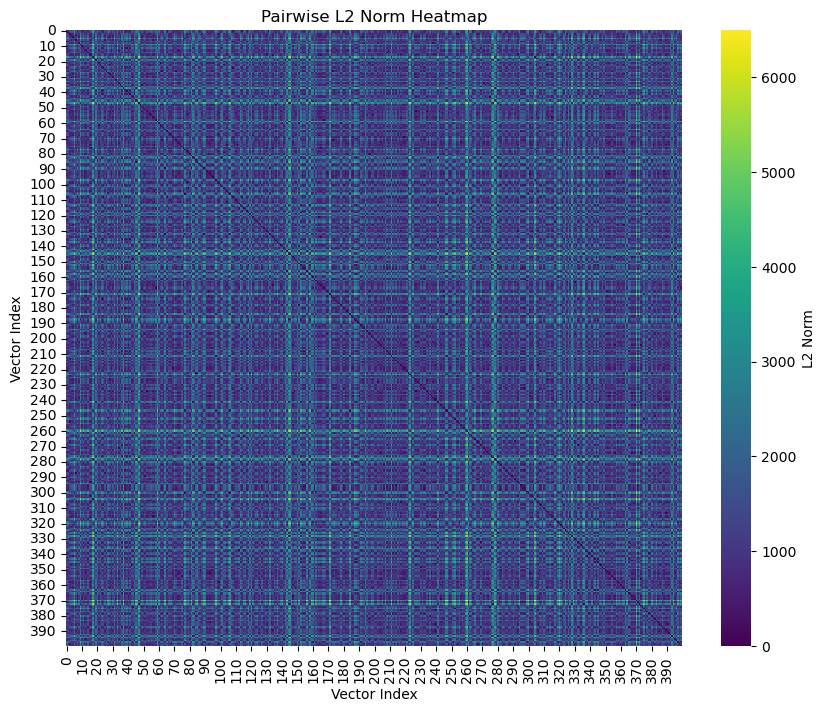

In [108]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(l2_distance_matrix, cmap='viridis', square=True, cbar_kws={'label': 'L2 Norm'})

# Add labels and title
plt.title('Pairwise L2 Norm Heatmap')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')

# Show the plot
plt.show()

L1-norm

In [109]:
abs_diffs = np.abs(loaded_array[:, np.newaxis, :] - loaded_array[np.newaxis, :, :])
sum_abs_diffs = np.sum(abs_diffs, axis=2)
l1_distance_matrix = sum_abs_diffs

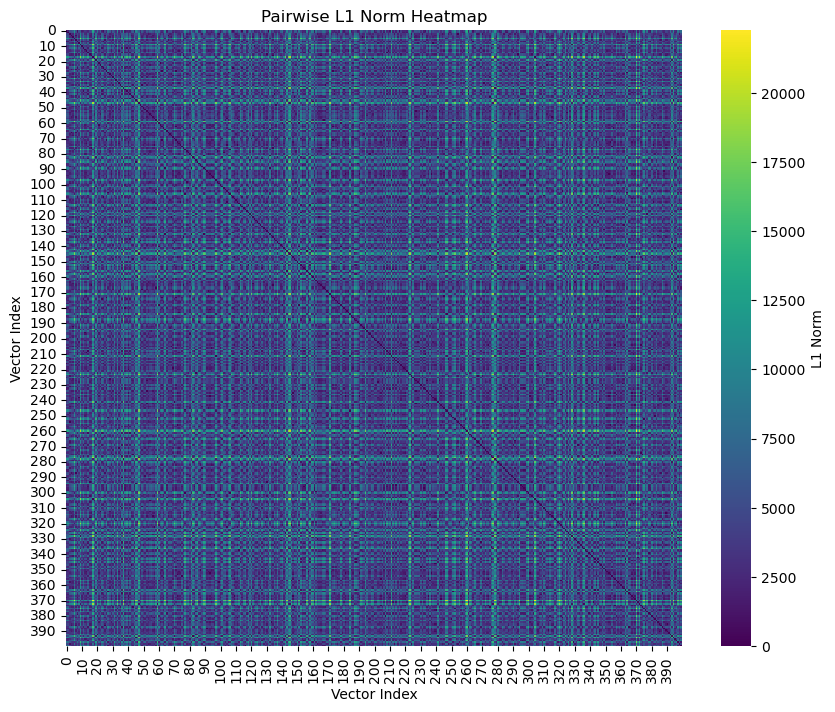

In [110]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(l1_distance_matrix, cmap='viridis', square=True, cbar_kws={'label': 'L1 Norm'})

# Add labels and title
plt.title('Pairwise L1 Norm Heatmap')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')

# Show the plot
plt.show()

L_inf-norm

In [111]:
abs_diffs = np.abs(loaded_array[:, np.newaxis, :] - loaded_array[np.newaxis, :, :])
max_abs_diffs = np.max(abs_diffs, axis=2)
linf_distance_matrix = max_abs_diffs

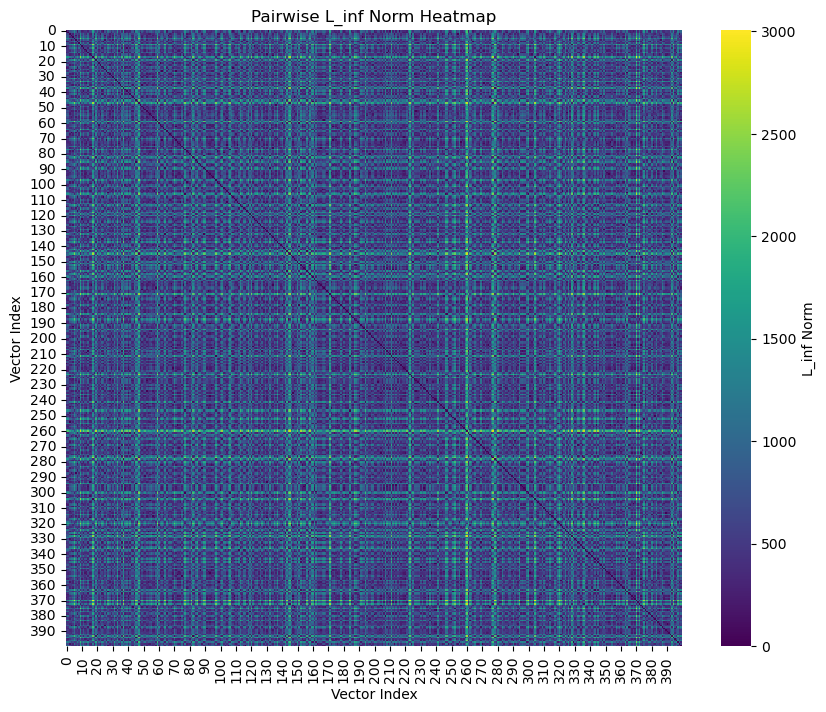

In [112]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(linf_distance_matrix, cmap='viridis', square=True, cbar_kws={'label': 'L_inf Norm'})

# Add labels and title
plt.title('Pairwise L_inf Norm Heatmap')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')

# Show the plot
plt.show()

In [114]:
# np.save('dipeptides_distance_matrix.npy', distance_matrix)

In [115]:
with open('smiles.csv', 'r') as f:
    smiles_list = [line.strip() for line in f]

len(smiles_list)

400

In [116]:
from rdkit import Chem
from rdkit.Chem import DataStructs, Draw
from itertools import combinations

# Function to compute Tanimoto similarity for all pairs in a list of SMILES
def compute_tanimoto_similarity_matrix(smiles_list, maxPath=10):
    """
    Compute Tanimoto similarity matrix for a list of SMILES strings.
    
    Args:
        smiles_list (list): List of SMILES strings.
        maxPath (int): Maximum path length for RDKit fingerprint.
    
    Returns:
        np.ndarray: A square similarity matrix (n x n) where n is the number of valid SMILES.
    """
    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    
    # Filter out invalid SMILES
    valid_mols = [mol for mol in mols if mol is not None]
    if len(valid_mols) < len(mols):
        print("Warning: Some SMILES strings were invalid and skipped.")
    
    # Generate fingerprints for all valid molecules
    fingerprints = [Chem.RDKFingerprint(mol, maxPath=maxPath) for mol in valid_mols]
    
    # Initialize an empty similarity matrix
    n = len(valid_mols)
    similarity_matrix = np.zeros((n, n))
    
    # Compute Tanimoto similarity for all pairs
    for i in range(n):
        for j in range(i, n):  # Only compute upper triangle (symmetry)
            similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Symmetric matrix
    
    return similarity_matrix

In [117]:
similarity_matrix = compute_tanimoto_similarity_matrix(smiles_list, maxPath=15)

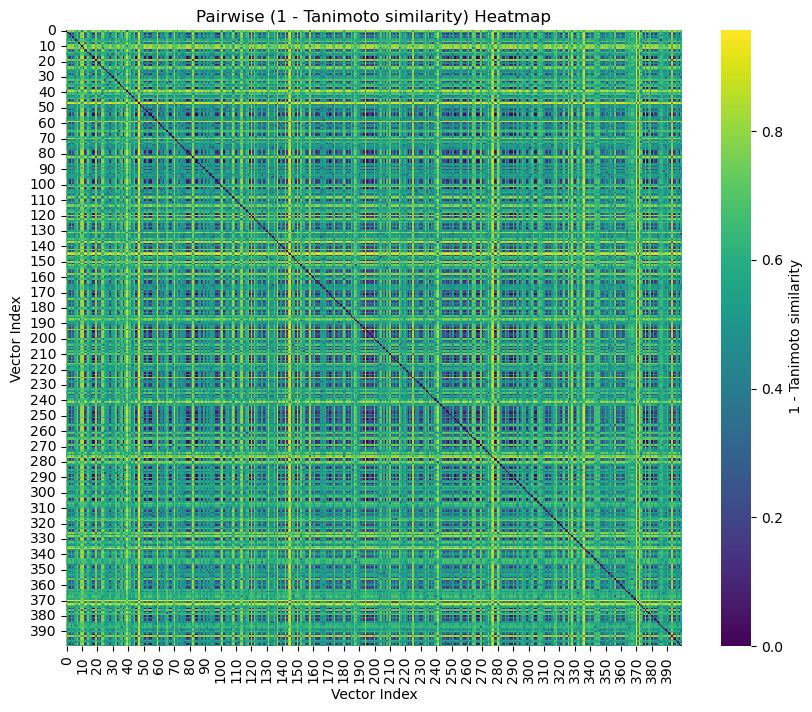

In [118]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(1 - similarity_matrix, cmap='viridis', square=True, cbar_kws={'label': ' 1 - Tanimoto similarity'})

# Add labels and title
plt.title('Pairwise (1 - Tanimoto similarity) Heatmap')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')

# Show the plot
plt.show()

$R^2$ distances

In [120]:
def normalization(matrix):
    return (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

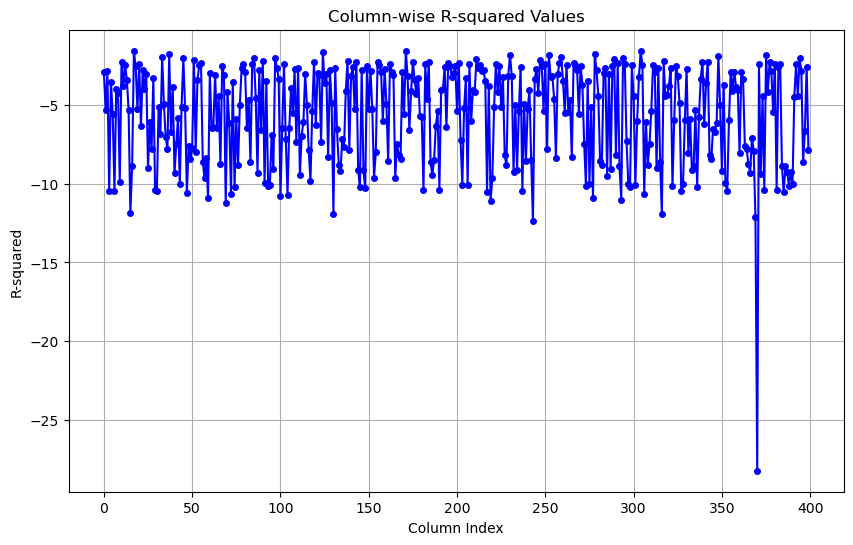

In [125]:
import numpy as np
from sklearn.metrics import r2_score

reference_matrix = similarity_matrix
#reference_upper = reference_matrix[np.triu_indices(400, k=1)]

distance_matrix = normalization(l2_distance_matrix)
#distance_upper = distance_matrix[np.triu_indices(400, k=1)]

# Compute column-wise R-squared
r2_values = []
for col in range(400):
    reference_col = reference_matrix[:, col]
    distance_col = distance_matrix[:, col]
    r2 = r2_score(reference_col, distance_col)
    r2_values.append(r2)

# Convert to a NumPy array
r2_values = np.array(r2_values)

# Plot the R-squared values
plt.figure(figsize=(10, 6))
plt.plot(r2_values, color='blue', marker='o', linestyle='-', markersize=4)
plt.title("Column-wise R-squared Values")
plt.xlabel("Column Index")
plt.ylabel("R-squared")
plt.grid(True)
plt.show()